In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

print("Google Drive mounted successfully.")

Mounted at /content/drive
Google Drive mounted successfully.


In [ ]:
!pip -q install -U datasets huggingface_hub

from huggingface_hub import notebook_login
notebook_login()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.3/563.3 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 20.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


In [ ]:
import os
HF_SOURCE = "moriyad/clause_minigraph_builder_final"        # existing dataset with JSON *strings* in prompt/completion
HF_TARGET = "moriyad/clause_minigraph_builder_grpo"  # new dataset repo to create/push
PRIVATE   = True

# Columns that hold JSON-as-string payloads
PROMPT_COL     = "prompt"
COMPLETION_COL = "completion"
STRIP_CODE_FENCES = False


In [ ]:
import re, json
from typing import Any, Dict
from tqdm.auto import tqdm

def calculate_lengths(example):
    # The 'prompt' field is a JSON string, so we need to parse it first
    prompt_json = json.loads(example['prompt'])
    prompt_text = json.dumps(prompt_json.get("input", {}))

    # The 'completion' is also a JSON string
    completion_text = example['completion']

    # Tokenize and get the lengths
    example['prompt_len'] = len(prompt_text)
    example['completion_len'] = len(completion_text)
    return example


BOX_BLOCK   = re.compile(r'[\u2500-\u257F]+')      # box-drawing / rules
ZWS_CHARS   = re.compile(r'[\u200B-\u200F\uFEFF]') # zero-width spacers
CTRL_CHARS  = re.compile(r'[\x00-\x08\x0B\x0C\x0E-\x1F\x7F]')  # keep \n and \t
MULTIBLANKS = re.compile(r'\n{3,}')
FENCES      = re.compile(r'```.*?```', re.S)

def strip_noise_text(s: str, strip_fences: bool = STRIP_CODE_FENCES) -> str:
    if not isinstance(s, str):
        return s
    t = s
    if strip_fences:
        t = FENCES.sub('', t)
    t = BOX_BLOCK.sub(' ', t)
    t = ZWS_CHARS.sub('', t)
    t = CTRL_CHARS.sub('', t)
    t = MULTIBLANKS.sub('\n\n', t)
    return t.strip()

def deep_clean(obj: Any) -> Any:
    if isinstance(obj, dict):
        return {k: deep_clean(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [deep_clean(x) for x in obj]
    if isinstance(obj, str):
        return strip_noise_text(obj)
    return obj

def clean_prompt_string(s: str) -> str:
    """Parse prompt JSON string → clean selected fields → dump JSON string."""
    try:
        p = json.loads(s)
        if isinstance(p, dict):
            # clean the instruction and common nested fields
            if "instruction" in p:
                p["instruction"] = strip_noise_text(p["instruction"])
            inp = p.get("input", {})
            if isinstance(inp, dict):
                clause = inp.get("clause", {})
                if isinstance(clause, dict):
                    if "text"  in clause: clause["text"]  = strip_noise_text(clause["text"])
                    if "title" in clause: clause["title"] = strip_noise_text(clause["title"])
        else:
            return strip_noise_text(s)
        return json.dumps(p, ensure_ascii=False)
    except Exception:
        return strip_noise_text(s)

def clean_completion_string(s: str) -> str:
    """Parse completion JSON string (nodes/edges), deep-clean any strings, dump back."""
    try:
        c = json.loads(s)
        c = deep_clean(c)
        return json.dumps(c, ensure_ascii=False)
    except Exception:
        # If completion sometimes contains extra prose, we still remove noise from the raw string
        return strip_noise_text(s)


In [ ]:
from datasets import load_dataset, DatasetDict

import numpy as np

ds = load_dataset(HF_SOURCE)
print(ds)

def clean_row(ex):
    if PROMPT_COL in ex:
        ex[PROMPT_COL] = clean_prompt_string(ex[PROMPT_COL])
    if COMPLETION_COL in ex:
        ex[COMPLETION_COL] = clean_completion_string(ex[COMPLETION_COL])
    return ex

ds_clean = ds.map(clean_row, num_proc=4, desc="Cleaning JSON strings")
print(ds_clean)


print("Calculating token lengths for all records... (This may take a minute)")
dataset_with_lengths = ds.map(calculate_lengths, num_proc=os.cpu_count())

print("\n✅ Length calculation complete. Added 'prompt_len' and 'completion_len' columns.")
display(dataset_with_lengths['train'].to_pandas().head())

prompt_threshold = int(np.percentile(dataset_with_lengths['train']['prompt_len'], 95))
completion_threshold = int(np.percentile(dataset_with_lengths['train']['completion_len'], 95))

print("="*50)
print("              Filtering Thresholds")
print("="*50)
print(f"Prompt Length 95th Percentile: {prompt_threshold} tokens")
print(f"Completion Length 95th Percentile: {completion_threshold} tokens")
print("\nRecords with prompts OR completions longer than these values will be removed.")



README.md:   0%|          | 0.00/679 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/206k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/217k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1918 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/239 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/228 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'contract_id', 'clause_id', 'prompt', 'completion'],
        num_rows: 1918
    })
    validation: Dataset({
        features: ['id', 'contract_id', 'clause_id', 'prompt', 'completion'],
        num_rows: 239
    })
    test: Dataset({
        features: ['id', 'contract_id', 'clause_id', 'prompt', 'completion'],
        num_rows: 228
    })
})


Cleaning JSON strings (num_proc=4):   0%|          | 0/1918 [00:00<?, ? examples/s]

Cleaning JSON strings (num_proc=4):   0%|          | 0/239 [00:00<?, ? examples/s]

Cleaning JSON strings (num_proc=4):   0%|          | 0/228 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'contract_id', 'clause_id', 'prompt', 'completion'],
        num_rows: 1918
    })
    validation: Dataset({
        features: ['id', 'contract_id', 'clause_id', 'prompt', 'completion'],
        num_rows: 239
    })
    test: Dataset({
        features: ['id', 'contract_id', 'clause_id', 'prompt', 'completion'],
        num_rows: 228
    })
})
Calculating token lengths for all records... (This may take a minute)


Map (num_proc=2):   0%|          | 0/1918 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/239 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/228 [00:00<?, ? examples/s]


✅ Length calculation complete. Added 'prompt_len' and 'completion_len' columns.


,id,contract_id,clause_id,prompt,completion,prompt_len,completion_len
0,AIRSPANNETWORKSINC_04_11_2000-EX-10.5-Distribu...,AIRSPANNETWORKSINC_04_11_2000-EX-10.5-Distribu...,10.3,"{""instruction"": ""Your task is to act as a lega...","{""contract_id"": ""AIRSPANNETWORKSINC_04_11_2000...",443,875
1,"GOOSEHEADINSURANCE,INC_04_02_2018-EX-10.6-Fran...","GOOSEHEADINSURANCE,INC_04_02_2018-EX-10.6-Fran...",4.3.6,"{""instruction"": ""Your task is to act as a lega...","{""contract_id"": ""GOOSEHEADINSURANCE,INC_04_02_...",409,989
2,ENTERTAINMENTGAMINGASIAINC_02_15_2005-EX-10.5-...,ENTERTAINMENTGAMINGASIAINC_02_15_2005-EX-10.5-...,26,"{""instruction"": ""Your task is to act as a lega...","{""contract_id"": ""ENTERTAINMENTGAMINGASIAINC_02...",561,304
3,FUSIONPHARMACEUTICALSINC_06_05_2020-EX-10.17-S...,FUSIONPHARMACEUTICALSINC_06_05_2020-EX-10.17-S...,(b,"{""instruction"": ""Your task is to act as a lega...","{""contract_id"": ""FUSIONPHARMACEUTICALSINC_06_0...",233,423
4,HealthcareIntegratedTechnologiesInc_20190812_8...,HealthcareIntegratedTechnologiesInc_20190812_8...,1.6,"{""instruction"": ""Your task is to act as a lega...","{""contract_id"": ""HealthcareIntegratedTechnolog...",168,311


              Filtering Thresholds
Prompt Length 95th Percentile: 1495 tokens
Completion Length 95th Percentile: 1596 tokens

Records with prompts OR completions longer than these values will be removed.


In [ ]:

print("\nFiltering dataset...")
filtered_dataset = dataset_with_lengths.filter(
    lambda x: x['prompt_len'] <= prompt_threshold and x['completion_len'] <= completion_threshold,
    num_proc=os.cpu_count()
)
print("✅ Filtering complete.")

print("\n" + "="*50)
print("                 Dataset Size Comparison")
print("="*50)
for split in ds.keys():
    original_size = len(ds[split])
    filtered_size = len(filtered_dataset[split])
    removed_count = original_size - filtered_size
    removed_percent = (removed_count / original_size) * 100 if original_size > 0 else 0
    print(f"\nSplit: '{split}'")
    print(f"  Original size: {original_size:>5,} records")
    print(f"  Filtered size: {filtered_size:>5,} records")
    print(f"  Removed:       {removed_count:>5,} records ({removed_percent:.2f}%)")




Filtering dataset...


Filter (num_proc=2):   0%|          | 0/1918 [00:00<?, ? examples/s]

Filter (num_proc=2):   0%|          | 0/239 [00:00<?, ? examples/s]

Filter (num_proc=2):   0%|          | 0/228 [00:00<?, ? examples/s]

✅ Filtering complete.

                 Dataset Size Comparison

Split: 'train'
  Original size: 1,918 records
  Filtered size: 1,744 records
  Removed:         174 records (9.07%)

Split: 'validation'
  Original size:   239 records
  Filtered size:   226 records
  Removed:          13 records (5.44%)

Split: 'test'
  Original size:   228 records
  Filtered size:   198 records
  Removed:          30 records (13.16%)


In [ ]:
#Quick spot check (first item of each split)
for split in filtered_dataset.keys():
    sample = filtered_dataset[split][0]
    print(f"\n[{split}] sample keys:", list(sample.keys()))
    print(f"prompt (first 400 chars):\n{sample[PROMPT_COL][:400] if PROMPT_COL in sample else 'N/A'}")

filtered_dataset.keys()


[train] sample keys: ['id', 'contract_id', 'clause_id', 'prompt', 'completion', 'prompt_len', 'completion_len']
prompt (first 400 chars):
{"instruction": "Your task is to act as a legal graph extractor. From this single clause, create a self-contained set of nodes and edges that are explicitly supported by the text. Follow the reasoning process, rules, and clarifications below.\n\nOutput ONLY a single, strict JSON object with this structure:\n\n{\n \"contract_id\": \"...\",\n \"nodes\": [ ... ],\n \"edges\": [ ... ]\n}\n\n \nREASONI

[validation] sample keys: ['id', 'contract_id', 'clause_id', 'prompt', 'completion', 'prompt_len', 'completion_len']
prompt (first 400 chars):
{"instruction": "Your task is to act as a legal graph extractor. From this single clause, create a self-contained set of nodes and edges that are explicitly supported by the text. Follow the reasoning process, rules, and clarifications below.\n\nOutput ONLY a single, strict JSON object with this structure:\n\n{\n \

dict_keys(['train', 'validation', 'test'])

In [ ]:
final_dataset = DatasetDict({
    'train': filtered_dataset['train'].remove_columns(['prompt_len', 'completion_len']),
    'validation': filtered_dataset['validation'].remove_columns(['prompt_len', 'completion_len']),
    'test': filtered_dataset['test'].remove_columns(['prompt_len', 'completion_len'])
})
for split in final_dataset.keys():
    sample = final_dataset[split][0]
    print(f"\n[{split}] sample keys:", list(sample.keys()))
    print(f"prompt (first 400 chars):\n{sample[PROMPT_COL][:400] if PROMPT_COL in sample else 'N/A'}")

final_dataset.keys()


[train] sample keys: ['id', 'contract_id', 'clause_id', 'prompt', 'completion']
prompt (first 400 chars):
{"instruction": "Your task is to act as a legal graph extractor. From this single clause, create a self-contained set of nodes and edges that are explicitly supported by the text. Follow the reasoning process, rules, and clarifications below.\n\nOutput ONLY a single, strict JSON object with this structure:\n\n{\n \"contract_id\": \"...\",\n \"nodes\": [ ... ],\n \"edges\": [ ... ]\n}\n\n \nREASONI

[validation] sample keys: ['id', 'contract_id', 'clause_id', 'prompt', 'completion']
prompt (first 400 chars):
{"instruction": "Your task is to act as a legal graph extractor. From this single clause, create a self-contained set of nodes and edges that are explicitly supported by the text. Follow the reasoning process, rules, and clarifications below.\n\nOutput ONLY a single, strict JSON object with this structure:\n\n{\n \"contract_id\": \"...\",\n \"nodes\": [ ... ],\n \"edges\": [ ..

dict_keys(['train', 'validation', 'test'])

In [ ]:
for split in filtered_dataset.keys():
    sample = filtered_dataset[split][0]
    print(f"\n[{split}] sample keys:", list(sample.keys()))



[train] sample keys: ['id', 'contract_id', 'clause_id', 'prompt', 'completion', 'prompt_len', 'completion_len']

[validation] sample keys: ['id', 'contract_id', 'clause_id', 'prompt', 'completion', 'prompt_len', 'completion_len']

[test] sample keys: ['id', 'contract_id', 'clause_id', 'prompt', 'completion', 'prompt_len', 'completion_len']


In [ ]:
#Push new dataset to hf

final_dataset.push_to_hub(HF_TARGET, private=PRIVATE)
print(f"\nPushed cleaned dataset → {HF_TARGET}")


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]


Pushed cleaned dataset → moriyad/clause_minigraph_builder_grpo


In [ ]:
#@title DataSet Explorer
from pathlib import Path

DRIVE_ROOT = Path("/content/drive/MyDrive")
INPUT_DIR_PATH = DRIVE_ROOT / "sft_minigraph_openai_full/v4/pairs"
OUTPUT_DIR_NAME = DRIVE_ROOT / "minigraph_fixed"

INPUT_DIR = DRIVE_ROOT / INPUT_DIR_PATH
OUTPUT_DIR = DRIVE_ROOT / OUTPUT_DIR_NAME

print(f"Input directory is set to: {INPUT_DIR}")
print(f"Output directory will be: {OUTPUT_DIR}")

Input directory is set to: /content/drive/MyDrive/sft_minigraph_openai_full/v4/pairs
Output directory will be: /content/drive/MyDrive/minigraph_fixed


In [ ]:
import json
import shutil

def is_valid_edge(edge: dict) -> bool:
    """
    Checks if an edge is valid based on the provided rules.
    Returns True if valid, False otherwise.
    """
    src = edge.get("src", "")
    tgt = edge.get("tgt", "")
    edge_type = edge.get("type", "")

    # Helper functions to check node type based on ID prefix
    is_clause = lambda node_id: not any(p in str(node_id) for p in ["term:", "party:", "value:"])
    is_term = lambda node_id: str(node_id).startswith("term:")
    is_party = lambda node_id: str(node_id).startswith("party:")
    is_value = lambda node_id: str(node_id).startswith("value:")

    if edge_type == "IS_PART_OF":
        return is_clause(src) and is_clause(tgt)
    elif edge_type == "DEFINES":
        return is_clause(src) and is_term(tgt)
    elif edge_type == "USES":
        return is_clause(src) and is_term(tgt)
    elif edge_type == "REFERENCES":
        return is_clause(src) and is_clause(tgt)
    elif edge_type == "MENTIONS_PARTY":
        return is_clause(src) and is_party(tgt)
    elif edge_type == "CONTAINS":
        return is_clause(src) and is_value(tgt)

    return False

def process_minigraph_files(input_dir, output_dir):
    """
    Reads all JSON files from input_dir, cleans them according to the rules,
    and writes the corrected files to output_dir.
    """
    if not input_dir.is_dir():
        print(f"❌ ERROR: Input directory not found at '{input_dir}'")
        print("Please update the INPUT_DIR_PATH variable in Step 2 and run that cell again.")
        return

    if output_dir.exists():
        print(f"⚠️  Output directory '{output_dir}' already exists. Clearing it.")
        shutil.rmtree(output_dir)
    output_dir.mkdir(parents=True)
    print(f"✅ Created new output directory: '{output_dir}'")

    file_count = 0
    processed_count = 0
    for file_path in input_dir.glob("*.json"):
        file_count += 1

        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)

            graph = data.get("completion", {})
            if not isinstance(graph, dict) or "nodes" not in graph or "edges" not in graph:
                print(f"  - ⚠️  WARNING: Skipping {file_path.name}. 'completion' block with nodes/edges not found.")
                continue

            valid_edges = [edge for edge in graph.get("edges", []) if is_valid_edge(edge)]

            #De-duplicate edges
            deduplicated_edges = []
            seen_edges = set()
            for edge in valid_edges:
                edge_tuple = (edge.get("src"), edge.get("tgt"), edge.get("type"))
                if edge_tuple not in seen_edges:
                    seen_edges.add(edge_tuple)
                    deduplicated_edges.append(edge)

            #De-duplicate nodes
            deduplicated_nodes = []
            seen_node_ids = set()
            for node in graph.get("nodes", []):
                node_id = node.get("id")
                if node_id and node_id not in seen_node_ids:
                    seen_node_ids.add(node_id)
                    deduplicated_nodes.append(node)

            cleaned_data = {
                "prompt": data.get("prompt", {}),
                "completion": {
                    "contract_id": graph.get("contract_id", "Unknown"),
                    "nodes": sorted(deduplicated_nodes, key=lambda x: str(x.get("id", ""))),
                    "edges": sorted(deduplicated_edges, key=lambda x: (str(x.get("src", "")), str(x.get("tgt", "")), str(x.get("type", ""))))
                }
            }

            output_file_path = output_dir / file_path.name
            with open(output_file_path, 'w', encoding='utf-8') as f:
                json.dump(cleaned_data, f, indent=2)

            processed_count += 1

        except json.JSONDecodeError:
            print(f"  - ❌ ERROR: Invalid JSON in {file_path.name}. Skipping.")
        except Exception as e:
            print(f"  - ❌ ERROR: An unexpected error occurred with {file_path.name}: {e}")

    print("\n" + "="*40)
    print("         Processing Complete")
    print("="*40)
    print(f"Total files found in input directory: {file_count}")
    print(f"Successfully processed and written: {processed_count}")
    print(f"Cleaned files are located in: '{output_dir}'")

In [ ]:
process_minigraph_files(INPUT_DIR, OUTPUT_DIR)

⚠️  Output directory '/content/drive/MyDrive/minigraph_fixed' already exists. Clearing it.
✅ Created new output directory: '/content/drive/MyDrive/minigraph_fixed'

         Processing Complete
Total files found in input directory: 2599
Successfully processed and written: 2599
Cleaned files are located in: '/content/drive/MyDrive/minigraph_fixed'


In [ ]:
INPUT_DIR_PATH = "minigraph_fixed"

OUTPUT_DIR_NAME = "minigraph_fixed_pairs_by_contract"

INPUT_DIR = DRIVE_ROOT / INPUT_DIR_PATH
OUTPUT_DIR = DRIVE_ROOT / OUTPUT_DIR_NAME

print(f"Input directory (source of files) is set to: {INPUT_DIR}")
print(f"Output directory (destination) will be: {OUTPUT_DIR}")


Input directory (source of files) is set to: /content/drive/MyDrive/minigraph_fixed
Output directory (destination) will be: /content/drive/MyDrive/minigraph_fixed_pairs_by_contract


In [ ]:
import json
import shutil
import re

def sanitize_directory_name(name: str) -> str:
    """
    Removes or replaces characters that are invalid in directory names.
    """
    # Replace slashes, backslashes, colons with an underscore
    name = re.sub(r'[\\/:]', '_', name)
    # Remove other invalid characters
    name = re.sub(r'[<>\"|?*]', '', name)
    return name

def group_files_by_contract(input_dir, output_dir):
    """
    Reads all JSON files from input_dir, extracts their contract_id, and
    copies them into sub-directories named after the contract_id inside output_dir.
    """
    if not input_dir.is_dir():
        print(f"❌ ERROR: Input directory not found at '{input_dir}'")
        print("Please ensure the path in Step 2 is correct and the previous script has been run.")
        return

    if output_dir.exists():
        print(f"⚠️  Output directory '{output_dir}' already exists. Clearing it for a fresh start.")
        shutil.rmtree(output_dir)
    output_dir.mkdir(parents=True)
    print(f"✅ Created new main output directory: '{output_dir}'")

    file_count = 0
    grouped_count = 0
    contract_folders = set()

    for file_path in input_dir.glob("*.json"):
        file_count += 1

        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)

            contract_id = data.get("completion", {}).get("contract_id")

            if not contract_id:
                print(f"  - ⚠️  WARNING: Skipping {file_path.name}. Could not find 'contract_id'.")
                continue

            sanitized_id = sanitize_directory_name(contract_id)
            contract_dir = output_dir / sanitized_id
            contract_dir.mkdir(parents=True, exist_ok=True)
            contract_folders.add(sanitized_id)

            destination_path = contract_dir / file_path.name
            shutil.copy(file_path, destination_path)
            grouped_count += 1

        except json.JSONDecodeError:
            print(f"  - ❌ ERROR: Invalid JSON in {file_path.name}. Skipping.")
        except Exception as e:
            print(f"  - ❌ ERROR: An unexpected error occurred with {file_path.name}: {e}")

    print("\n" + "="*40)
    print("         Grouping Complete")
    print("="*40)
    print(f"Total files found in input directory: {file_count}")
    print(f"Successfully grouped and copied: {grouped_count}")
    print(f"Created {len(contract_folders)} contract sub-directories.")
    print(f"Organized files are located in: '{output_dir}'")

In [ ]:
group_files_by_contract(INPUT_DIR, OUTPUT_DIR)


⚠️  Output directory '/content/drive/MyDrive/minigraph_fixed_pairs_by_contract' already exists. Clearing it for a fresh start.
✅ Created new main output directory: '/content/drive/MyDrive/minigraph_fixed_pairs_by_contract'

         Grouping Complete
Total files found in input directory: 2599
Successfully grouped and copied: 2599
Created 42 contract sub-directories.
Organized files are located in: '/content/drive/MyDrive/minigraph_fixed_pairs_by_contract'


In [ ]:

!pip -q install "orjson>=3.10.0" "tqdm>=4.66.0" "datasets>=2.20.0"

import os, re, glob, random, json
from pathlib import Path
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
import orjson, tqdm
import os, re, glob, json, math, random
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from datasets import load_dataset, DatasetDict, Features, Value

from google.colab import drive
drive.mount('/content/drive')
DRIVE_ROOT = "/content/drive/MyDrive/minigraph_fixed_pairs_by_contract"  # each subdir = one contract
WORK_ROOT  = "/content/workdata/sft_minigraph_xai_debug"
OUT_JSONL_DIR    = "/content/drive/MyDrive/sft_minigraph_xai_debug/contract_minigraphs_jsonl"
SEED = 42
SPLIT_RATIOS = (0.8, 0.1, 0.1)
MAX_WORKERS = 16

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Prep Contracts For Visualization
!pip -q install "orjson>=3.10.0" "tqdm>=4.66.0" "datasets>=2.20.0"

import os
import re
import glob
import random
import json
import math
from pathlib import Path
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
import orjson
import tqdm

from datasets import load_dataset, DatasetDict, Features, Value

from google.colab import drive
drive.mount('/content/drive')

DRIVE_ROOT = "/content/drive/MyDrive/minigraph_fixed_pairs_by_contract"
WORK_ROOT  = "/content/workdata/sft_minigraph_xai_temp"
OUT_DIR    = "/content/drive/MyDrive/minigraph_fixed_pairs_by_contract/contract_minigraphs_jsonl"
SEED = 42
SPLIT_RATIOS = (0.8, 0.1, 0.1)
MAX_WORKERS = 16

#Copy Drive -> local SSD for speed =========
Path(WORK_ROOT).parent.mkdir(parents=True, exist_ok=True)
print("Syncing from Drive to local SSD…")
!rsync -a --delete --info=progress2 "{DRIVE_ROOT}/" "{WORK_ROOT}/"
print("Done copying.\n")

rng = random.Random(SEED)
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

def list_contract_dirs(root: str):
    """Returns a sorted list of directories directly under the root."""
    return sorted([p.path for p in os.scandir(root) if p.is_dir()])

def json_files_under(d: str):
    """Returns a sorted list of all .json files under a directory."""
    return sorted(glob.glob(os.path.join(d, "**/*.json"), recursive=True))

CLAUSE_RE = re.compile(r"([0-9]+(?:\.[0-9A-Za-z\-]+)*)")
def clause_id_from_filename(fname: str) -> str:
    """Extracts a clause ID from a filename."""
    base = os.path.splitext(os.path.basename(fname))[0]
    m = CLAUSE_RE.search(base)
    return m.group(1) if m else base

def read_json_file(path: str):
    """Robustly reads a JSON file that might contain a single object or a list."""
    try:
        with open(path, "rb") as f:
            obj = orjson.loads(f.read())

        if isinstance(obj, dict):
            return [obj]
        return []
    except Exception:
        return []

def to_text(x):
    """Coerces any value to a string, using compact JSON for dicts/lists."""
    if isinstance(x, str):
        return x
    return orjson.dumps(x).decode("utf-8")

def normalize_record(r: dict, contract_id: str, src_path: str, idx: int):
    """Creates a clean, flat record from a raw JSON object."""
    prompt_data = r.get("prompt", {})
    completion_data = r.get("completion", {})

    if not prompt_data or not completion_data:
        return None

    prompt_str = to_text(prompt_data)
    completion_str = to_text(completion_data)

    stem = os.path.splitext(os.path.basename(src_path))[0]
    final_contract_id = completion_data.get("contract_id", contract_id)
    # Generate a unique ID for the row
    rid = f"{final_contract_id}/{stem}"

    clause_id = completion_data.get("clause_id") or prompt_data.get("input", {}).get("clause", {}).get("id") or clause_id_from_filename(src_path)

    return {
        "id": rid,
        "contract_id": final_contract_id,
        "clause_id": str(clause_id), # Ensure clause_id is a string
        "prompt": prompt_str,
        "completion": completion_str,
    }

def parse_file(path: str, contract_id: str):
    """Parses a single JSON file and returns a list of normalized records."""
    rows_raw = read_json_file(path)
    out = []
    for i, rec in enumerate(rows_raw):
        nr = normalize_record(rec, contract_id, path, i)
        if nr:
            out.append(nr)
    return out

contract_dirs = list_contract_dirs(WORK_ROOT)
print(f"Found {len(contract_dirs)} contract folders")

by_contract = defaultdict(list)
total_files = 0

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
    futs = []
    for cdir in contract_dirs:
        cid = os.path.basename(cdir)
        files = json_files_under(cdir)
        total_files += len(files)
        for p in files:
            futs.append(ex.submit(parse_file, p, cid))

    for fut in tqdm.tqdm(as_completed(futs), total=len(futs), desc="Parsing JSON"):
        rows = fut.result()
        if not rows:
            continue
        # Group rows by the contract_id found within the file content
        for row in rows:
             by_contract[row["contract_id"]].append(row)

total_rows = sum(len(v) for v in by_contract.values())
print(f"Files scanned: {total_files} | Parsed rows kept: {total_rows}")


def split_groups_greedy(by_group, ratios=(0.8, 0.1, 0.1)):
    """Splits contracts into train/val/test sets, ensuring no contract leakage."""
    groups = sorted(by_group.items(), key=lambda kv: len(kv[1]), reverse=True)
    n_total = sum(len(v) for _, v in groups)

    # Calculate target sizes for each split
    targets = [int(round(n_total * r)) for r in ratios]

    splits = [[], [], []]  # List of contract IDs for each split
    counts = [0, 0, 0]     # Number of examples in each split

    for group_id, rows in groups:
        fullness = [counts[i] / max(1, targets[i]) for i in range(3)]
        best_split_idx = min(range(3), key=lambda i: fullness[i])

        splits[best_split_idx].append(group_id)
        counts[best_split_idx] += len(rows)

    return splits, counts, targets

(s_train, s_val, s_test), counts, targets = split_groups_greedy(by_contract, ratios=SPLIT_RATIOS)

print("\n--- Data Splitting Results ---")
print(f"Contracts per split (train/val/test): {len(s_train)} / {len(s_val)} / {len(s_test)}")
print(f"Examples per split (actual vs target):")
print(f"  Train: {counts[0]:>5} / {targets[0]}")
print(f"  Val:   {counts[1]:>5} / {targets[1]}")
print(f"  Test:  {counts[2]:>5} / {targets[2]}")

def collect_rows_from_ids(contract_ids, all_data):
    """Collects all rows for a list of contract IDs and shuffles them."""
    out = [row for cid in contract_ids for row in all_data[cid]]
    rng.shuffle(out)
    return out

train_rows = collect_rows_from_ids(s_train, by_contract)
val_rows   = collect_rows_from_ids(s_val, by_contract)
test_rows  = collect_rows_from_ids(s_test, by_contract)

print(f"\nFinal split sizes: train={len(train_rows)}, val={len(val_rows)}, test={len(test_rows)}")

def write_jsonl_corrected(path: str, rows: list):
    """
    Writes a list of dictionary rows to a JSONL file.
    This version assumes every row is a valid dictionary.
    """
    with open(path, "w", encoding="utf-8") as f:
        for row in rows:
            if not isinstance(row, dict):
                print(f"WARNING: Skipping a non-dictionary item in the dataset: {row}")
                continue
            f.write(orjson.dumps(row).decode('utf-8') + "\n")

train_path = os.path.join(OUT_DIR, "train.jsonl")
val_path   = os.path.join(OUT_DIR, "validation.jsonl")
test_path  = os.path.join(OUT_DIR, "test.jsonl")

print("\n--- Writing JSONL Files ---")
write_jsonl_corrected(train_path, train_rows)
write_jsonl_corrected(val_path,   val_rows)
write_jsonl_corrected(test_path,  test_rows)

for p in (train_path, val_path, test_path):
    print(f"{p}: size = {os.path.getsize(p):,} bytes")


print("\n--- Verifying with Hugging Face datasets library ---")

features = Features({
    "id":          Value("string"),
    "contract_id": Value("string"),
    "clause_id":   Value("string"),
    "prompt":      Value("string"),
    "completion":  Value("string"),
})

try:
    ds = DatasetDict({
        "train":      load_dataset("json", data_files=train_path, split="train", features=features),
        "validation": load_dataset("json", data_files=val_path,   split="train", features=features),
        "test":       load_dataset("json", data_files=test_path,  split="train", features=features),
    })
    print("\n✅ Successfully loaded dataset into DatasetDict:")
    print(ds)

    def check_types(dset, name):
        sample = dset.select(range(min(200, len(dset))))
        assert all(isinstance(x, str) for x in sample["prompt"])
        assert all(isinstance(x, str) for x in sample["completion"])
        print(f"  - {name}: OK, all columns are string types.")

    check_types(ds["train"], "train")
    check_types(ds["validation"], "validation")
    check_types(ds["test"], "test")

    def contracts_in(split): return set(split["contract_id"])
    leak = (contracts_in(ds["train"]) & contracts_in(ds["validation"])) \
         | (contracts_in(ds["train"]) & contracts_in(ds["test"])) \
         | (contracts_in(ds["validation"]) & contracts_in(ds["test"]))

    assert not leak, f"CRITICAL ERROR: Contract leakage across splits: {list(leak)[:5]}"
    print("  - ✅ No contract leakage detected across splits.")

except Exception as e:
    print("\n❌ An error occurred during dataset loading or validation.")
    print(e)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Syncing from Drive to local SSD…
     19,242,166 100%    1.35MB/s    0:00:13 (xfr#2599, to-chk=0/2642)
Done copying.

Found 42 contract folders


Parsing JSON: 100%|██████████| 2599/2599 [00:00<00:00, 116021.12it/s]


Files scanned: 2599 | Parsed rows kept: 2599

--- Data Splitting Results ---
Contracts per split (train/val/test): 35 / 3 / 4
Examples per split (actual vs target):
  Train:  2071 / 2079
  Val:     262 / 260
  Test:    266 / 260

Final split sizes: train=2071, val=262, test=266

--- Writing JSONL Files ---
/content/drive/MyDrive/minigraph_fixed_pairs_by_contract/contract_minigraphs_jsonl/train.jsonl: size = 13,897,019 bytes
/content/drive/MyDrive/minigraph_fixed_pairs_by_contract/contract_minigraphs_jsonl/validation.jsonl: size = 1,746,167 bytes
/content/drive/MyDrive/minigraph_fixed_pairs_by_contract/contract_minigraphs_jsonl/test.jsonl: size = 1,880,648 bytes

--- Verifying with Hugging Face datasets library ---


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]


✅ Successfully loaded dataset into DatasetDict:
DatasetDict({
    train: Dataset({
        features: ['id', 'contract_id', 'clause_id', 'prompt', 'completion'],
        num_rows: 2071
    })
    validation: Dataset({
        features: ['id', 'contract_id', 'clause_id', 'prompt', 'completion'],
        num_rows: 262
    })
    test: Dataset({
        features: ['id', 'contract_id', 'clause_id', 'prompt', 'completion'],
        num_rows: 266
    })
})
  - train: OK, all columns are string types.
  - validation: OK, all columns are string types.
  - test: OK, all columns are string types.
  - ✅ No contract leakage detected across splits.


In [ ]:
!pip -q install "datasets>=2.20.0" "huggingface_hub>=0.24.0"

from datasets import load_dataset, DatasetDict, Features, Value
from huggingface_hub import login, HfApi, whoami
import os, json

REPO_ID = "moriyad/clause_minigraph_builder_sft"
login()


In [ ]:


DATA_DIR = "/content/drive/MyDrive/minigraph_fixed_pairs_by_contract/contract_minigraphs_jsonl"
files = {
    "train":      f"{DATA_DIR}/train.jsonl",
    "validation": f"{DATA_DIR}/validation.jsonl",
    "test":       f"{DATA_DIR}/test.jsonl",
}

features = Features({
    "id":          Value("string"),
    "contract_id": Value("string"),
    "clause_id":   Value("string"),
    "prompt":      Value("string"),
    "completion":  Value("string"),
})

ds = DatasetDict({
    "train":      load_dataset("json", data_files=files["train"], split="train", features=features),
    "validation": load_dataset("json", data_files=files["validation"], split="train", features=features),
    "test":       load_dataset("json", data_files=files["test"], split="train", features=features),
})

ds.push_to_hub(REPO_ID, private=True)
print(f"Pushed to https://huggingface.co/datasets/{REPO_ID}")

card = """---
tags: [contracts, information-extraction, sft, json, legal]
task_categories: [text-generation]
license: other
pretty_name: Contract Clause Minigraph Creation
language: [en]
---

Clause-level **prompt → completion** pairs for training SFT models to identify mini graphs within commercial contracts.

- Split unit: **contract** (no clause leakage).
- Fields: `id`, `contract_id`, `clause_id`, `prompt`, `completion`.
- Splits: `train`, `validation`, `test`.
"""
api = HfApi()
api.upload_file(
    path_or_fileobj=card.encode("utf-8"),
    path_in_repo="README.md",
    repo_id=REPO_ID,
    repo_type="dataset"
)
print("README uploaded.")


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Pushed to https://huggingface.co/datasets/moriyad/clause_minigraph_builder_sft
README uploaded.


In [ ]:
import pandas as pd
from pathlib import Path
import json

# --- CONFIGURATION ---

# 1. Set the root path for your project
DRIVE_ROOT = Path("/content/drive/MyDrive")

# 2. Set the path to the directory containing your train.jsonl, validation.jsonl, and test.jsonl files
JSONL_DIR_PATH = "minigraph_fixed_pairs_by_contract/contract_minigraphs_jsonl"

# --- Do not edit below this line ---
JSONL_DIR = DRIVE_ROOT / JSONL_DIR_PATH

# --- Load Data ---
print(f"Searching for .jsonl files in: {JSONL_DIR}")

if not JSONL_DIR.is_dir():
    print(f"❌ ERROR: Directory not found. Please check the JSONL_DIR_PATH in this cell.")
else:
    data_files = list(JSONL_DIR.glob("*.jsonl"))
    if not data_files:
        print(f"❌ ERROR: No .jsonl files were found in the directory.")
    else:
        # Load all .jsonl files into a list of DataFrames
        df_list = [pd.read_json(f, lines=True) for f in data_files]
        # Concatenate them into a single DataFrame
        df = pd.concat(df_list, ignore_index=True)
        print(f"✅ Successfully loaded {len(df):,} total records from {len(data_files)} files.")
        print("\nHere's a sample of the loaded data:")
        display(df.head())

Searching for .jsonl files in: /content/drive/MyDrive/minigraph_fixed_pairs_by_contract/contract_minigraphs_jsonl
✅ Successfully loaded 2,599 total records from 3 files.

Here's a sample of the loaded data:


,id,contract_id,clause_id,prompt,completion
0,AIRSPANNETWORKSINC_04_11_2000-EX-10.5-Distribu...,AIRSPANNETWORKSINC_04_11_2000-EX-10.5-Distribu...,16.6,"{""instruction"":""\nYour task is to act as a leg...","{""contract_id"":""AIRSPANNETWORKSINC_04_11_2000-..."
1,"GOOSEHEADINSURANCE,INC_04_02_2018-EX-10.6-Fran...","GOOSEHEADINSURANCE,INC_04_02_2018-EX-10.6-Fran...",13.5,"{""instruction"":""\nYour task is to act as a leg...","{""contract_id"":""GOOSEHEADINSURANCE,INC_04_02_2..."
2,ENTERTAINMENTGAMINGASIAINC_02_15_2005-EX-10.5-...,ENTERTAINMENTGAMINGASIAINC_02_15_2005-EX-10.5-...,14.5,"{""instruction"":""\nYour task is to act as a leg...","{""contract_id"":""ENTERTAINMENTGAMINGASIAINC_02_..."
3,FUSIONPHARMACEUTICALSINC_06_05_2020-EX-10.17-S...,FUSIONPHARMACEUTICALSINC_06_05_2020-EX-10.17-S...,11,"{""instruction"":""\nYour task is to act as a leg...","{""contract_id"":""FUSIONPHARMACEUTICALSINC_06_05..."
4,HealthcareIntegratedTechnologiesInc_20190812_8...,HealthcareIntegratedTechnologiesInc_20190812_8...,1,"{""instruction"":""\nYour task is to act as a leg...","{""contract_id"":""HealthcareIntegratedTechnologi..."


In [ ]:
#@title Load jsonl files for analysis

from collections import Counter, defaultdict

def parse_completion_string(json_string):
    try:
        return json.loads(json_string)
    except (json.JSONDecodeError, TypeError):
        return {'nodes': [], 'edges': []}

df['completion_parsed'] = df['completion'].apply(parse_completion_string)
print("Parsed 'completion' column successfully.\n")


#Calculate Distributions
#Overall counters for the entire dataset
total_node_counts = Counter()
total_edge_counts = Counter()

#Per-contract counters
by_contract_stats = defaultdict(lambda: {'nodes': Counter(), 'edges': Counter()})

for index, row in df.iterrows():
    contract_id = row['contract_id']
    completion = row['completion_parsed']

    nodes = completion.get('nodes', [])
    edges = completion.get('edges', [])

    node_types = [node.get('node_type', 'Unknown') for node in nodes]
    edge_types = [edge.get('type', 'Unknown') for edge in edges]

    total_node_counts.update(node_types)
    total_edge_counts.update(edge_types)

    by_contract_stats[contract_id]['nodes'].update(node_types)
    by_contract_stats[contract_id]['edges'].update(edge_types)

print("Distribution calculations are complete.")

Parsed 'completion' column successfully.

Distribution calculations are complete.


In [ ]:
#@title Display Overall Dataset Summary

print("="*60)
print("          OVERALL DATASET DISTRIBUTION SUMMARY")
print("="*60)

print(f"\nTotal Contracts Analyzed: {len(by_contract_stats)}")
print(f"Total Clauses (Records): {len(df):,}")

print("\n--- Total Node Distribution (Entire Collection) ---")
if not total_node_counts:
    print("No nodes found in the dataset.")
else:
    total_nodes = sum(total_node_counts.values())
    print(f"Total Nodes: {total_nodes:,}\n")
    for node_type, count in total_node_counts.most_common():
        percentage = (count / total_nodes) * 100 if total_nodes > 0 else 0
        print(f"{node_type:<20}: {count:>8,} ({percentage:.2f}%)")

print("\n--- Total Edge Distribution (Entire Collection) ---")
if not total_edge_counts:
    print("No edges found in the dataset.")
else:
    total_edges = sum(total_edge_counts.values())
    print(f"Total Edges: {total_edges:,}\n")
    for edge_type, count in total_edge_counts.most_common():
        percentage = (count / total_edges) * 100 if total_edges > 0 else 0
        print(f"{edge_type:<20}: {count:>8,} ({percentage:.2f}%)")


#Display Per-Contract Breakdown ---

print("\n\n" + "="*60)
print("              PER-CONTRACT BREAKDOWN")
print("="*60)

sorted_contracts = sorted(by_contract_stats.keys())

for contract_id in sorted_contracts:
    stats = by_contract_stats[contract_id]
    total_contract_nodes = sum(stats['nodes'].values())
    total_contract_edges = sum(stats['edges'].values())

    print(f"\n--- Contract ID: {contract_id} ---")
    print(f"  Total Nodes: {total_contract_nodes:,} | Total Edges: {total_contract_edges:,}")

    print("  Node Counts:")
    if not stats['nodes']:
        print("    No nodes.")
    else:
        for node_type, count in stats['nodes'].most_common():
            print(f"    - {node_type:<20}: {count:,}")

    print("  Edge Counts:")
    if not stats['edges']:
        print("    No edges.")
    else:
        for edge_type, count in stats['edges'].most_common():
            print(f"    - {edge_type:<20}: {count:,}")

          OVERALL DATASET DISTRIBUTION SUMMARY

Total Contracts Analyzed: 42
Total Clauses (Records): 2,599

--- Total Node Distribution (Entire Collection) ---
Total Nodes: 17,921

DEFINED_TERM        :    6,708 (37.43%)
CLAUSE              :    5,846 (32.62%)
PARTY               :    4,138 (23.09%)
VALUE               :    1,229 (6.86%)

--- Total Edge Distribution (Entire Collection) ---
Total Edges: 15,388

USES                :    5,757 (37.41%)
MENTIONS_PARTY      :    4,256 (27.66%)
IS_PART_OF          :    2,219 (14.42%)
CONTAINS            :    1,230 (7.99%)
REFERENCES          :    1,046 (6.80%)
DEFINES             :      880 (5.72%)


              PER-CONTRACT BREAKDOWN

--- Contract ID: ACCURAYINC_09_01_2010-EX-10.31-DISTRIBUTOR AGREEMENT ---
  Total Nodes: 955 | Total Edges: 827
  Node Counts:
    - DEFINED_TERM        : 387
    - CLAUSE              : 321
    - PARTY               : 196
    - VALUE               : 51
  Edge Counts:
    - USES                : 352
    - M

In [1]:
#@title Plot Dataset Distributions

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 1, figsize=(12, 14))
fig.suptitle('Overall Node and Edge Type Distributions in the Dataset', fontsize=18, y=0.95)


#Node Distribution
if total_node_counts:
    node_df = pd.DataFrame(total_node_counts.most_common(), columns=['Node Type', 'Count'])
    sns.barplot(x='Count', y='Node Type', data=node_df, ax=axes[0], palette='viridis', orient='h')
    axes[0].set_title('Total Node Type Counts', fontsize=14)
    axes[0].set_xlabel('Total Count', fontsize=12)
    axes[0].set_ylabel('Node Type', fontsize=12)
    for i, v in enumerate(node_df['Count']):
        axes[0].text(v + 1, i, f'{v:,}', color='black', va='center')
else:
    axes[0].text(0.5, 0.5, 'No Node Data to Display', ha='center', va='center')


#Edge Distribution
if total_edge_counts:
    edge_df = pd.DataFrame(total_edge_counts.most_common(), columns=['Edge Type', 'Count'])
    sns.barplot(x='Count', y='Edge Type', data=edge_df, ax=axes[1], palette='plasma', orient='h')
    axes[1].set_title('Total Edge Type Counts', fontsize=14)
    axes[1].set_xlabel('Total Count', fontsize=12)
    axes[1].set_ylabel('Edge Type', fontsize=12)
    for i, v in enumerate(edge_df['Count']):
        axes[1].text(v + 1, i, f'{v:,}', color='black', va='center')
else:
    axes[1].text(0.5, 0.5, 'No Edge Data to Display', ha='center', va='center')


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

NameError: name 'plt' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path

sns.set_style("whitegrid")

def sanitize_filename(name: str) -> str:
    """Removes or replaces characters that are invalid in filenames."""
    name = re.sub(r'[\\/:"*?<>|]', '_', name)
    return name

def plot_contract_distribution(contract_id, stats_dict, save_to_dir=None):
    """
    Generates and displays or saves a visualization of node and edge distributions
    for a single contract.

    Args:
        contract_id (str): The ID of the contract to visualize.
        stats_dict (dict): The pre-computed by_contract_stats dictionary.
        save_to_dir (Path, optional): Directory to save the plot as a PNG.
                                      If None, displays the plot inline.
    """
    if contract_id not in stats_dict:
        print(f"❌ ERROR: Contract ID '{contract_id}' not found in the dataset.")
        return

    stats = stats_dict[contract_id]
    node_counts = stats['nodes']
    edge_counts = stats['edges']

    total_nodes = sum(node_counts.values())
    total_edges = sum(edge_counts.values())

    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    fig.suptitle(f'Distribution for Contract: {contract_id}\n(Total Nodes: {total_nodes:,} | Total Edges: {total_edges:,})',
                 fontsize=18, y=0.97)

    if node_counts:
        node_df = pd.DataFrame(node_counts.most_common(), columns=['Node Type', 'Count'])
        sns.barplot(x='Count', y='Node Type', data=node_df, ax=axes[0], palette='viridis', orient='h')
        axes[0].set_title('Node Type Counts', fontsize=14)
        axes[0].set_xlabel('Count', fontsize=12)
        axes[0].set_ylabel('')
        for i, v in enumerate(node_df['Count']):
            axes[0].text(v, i, f' {v:,}', color='black', va='center')
    else:
        axes[0].text(0.5, 0.5, 'No Node Data to Display', ha='center', va='center', fontsize=14)
        axes[0].set_xticks([])
        axes[0].set_yticks([])

    if edge_counts:
        edge_df = pd.DataFrame(edge_counts.most_common(), columns=['Edge Type', 'Count'])
        sns.barplot(x='Count', y='Edge Type', data=edge_df, ax=axes[1], palette='plasma', orient='h')
        axes[1].set_title('Edge Type Counts', fontsize=14)
        axes[1].set_xlabel('Count', fontsize=12)
        axes[1].set_ylabel('')
        for i, v in enumerate(edge_df['Count']):
            axes[1].text(v, i, f' {v:,}', color='black', va='center')
    else:
        axes[1].text(0.5, 0.5, 'No Edge Data to Display', ha='center', va='center', fontsize=14)
        axes[1].set_xticks([])
        axes[1].set_yticks([])

    # --- Save or Display the plot ---
    if save_to_dir:
        # Sanitize the contract ID to create a valid filename
        filename = f"{sanitize_filename(contract_id)}.png"
        filepath = save_to_dir / filename

        # Ensure the directory exists
        save_to_dir.mkdir(parents=True, exist_ok=True)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(filepath, bbox_inches='tight', dpi=100)
        plt.close(fig) # Close the figure to prevent it from displaying in the notebook
    else:
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

print("✅ Plotting function 'plot_contract_distribution' is now defined.")

✅ Plotting function 'plot_contract_distribution' is now defined.


Generating an example plot for Contract ID: 'AIRSPANNETWORKSINC_04_11_2000-EX-10.5-Distributor Agreement'


/tmp/ipython-input-3530314819.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Node Type', data=node_df, ax=axes[0], palette='viridis', orient='h')
/tmp/ipython-input-3530314819.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Edge Type', data=edge_df, ax=axes[1], palette='plasma', orient='h')


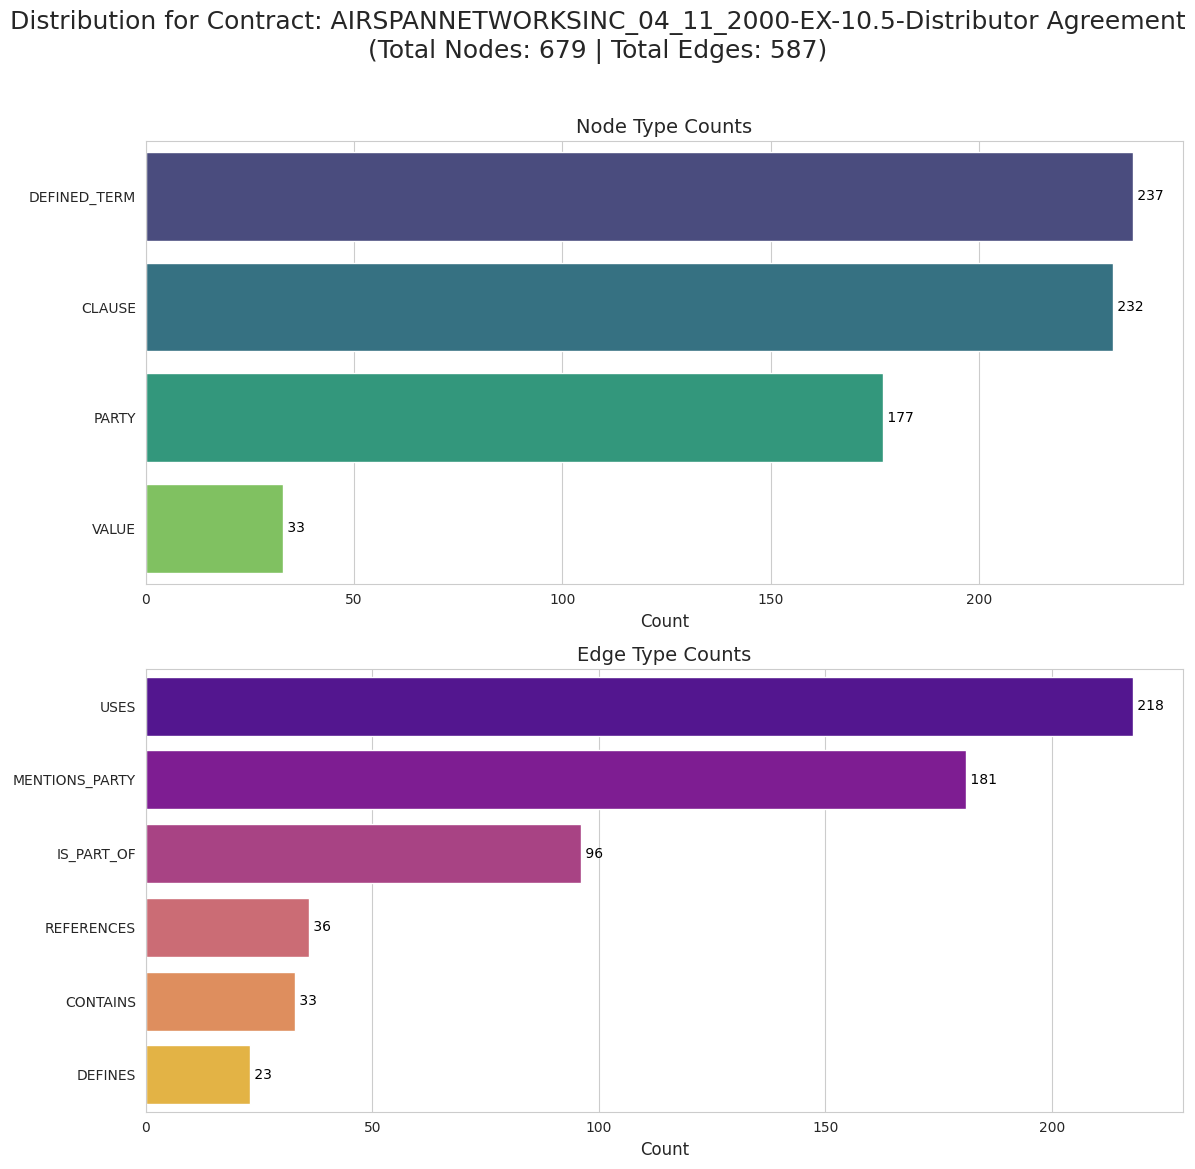

In [ ]:
#@title Plot a specific contract distribution

# We'll just grab the first contract ID from our stats dictionary as an example.
if by_contract_stats:
    sample_contract_id = list(by_contract_stats.keys())[0]
    print(f"Generating an example plot for Contract ID: '{sample_contract_id}'")

    plot_contract_distribution(sample_contract_id, by_contract_stats)
else:
    print("No contract data available to plot.")

In [ ]:
from tqdm.notebook import tqdm

#Creating all plots
PLOTS_OUTPUT_DIR_NAME = "contract_distribution_plots"
PLOTS_OUTPUT_DIR = DRIVE_ROOT / PLOTS_OUTPUT_DIR_NAME

print(f"Preparing to save all contract plots to: {PLOTS_OUTPUT_DIR}")

if not by_contract_stats:
    print("No contract data available to process.")
else:
    for contract_id in tqdm(by_contract_stats.keys(), desc="Generating and Saving Plots"):
        plot_contract_distribution(contract_id, by_contract_stats, save_to_dir=PLOTS_OUTPUT_DIR)

    print(f"\n✅ All done! {len(by_contract_stats)} plots have been saved to the '{PLOTS_OUTPUT_DIR_NAME}' folder in your Google Drive.")

Preparing to save all contract plots to: /content/drive/MyDrive/contract_distribution_plots


Generating and Saving Plots:   0%|          | 0/42 [00:00<?, ?it/s]

/tmp/ipython-input-3530314819.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Node Type', data=node_df, ax=axes[0], palette='viridis', orient='h')
/tmp/ipython-input-3530314819.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Edge Type', data=edge_df, ax=axes[1], palette='plasma', orient='h')
/tmp/ipython-input-3530314819.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Node Type', data=node_df, ax=axes[0], palette='viridis', orient='h')
/tmp/ipython-input-3530314819.py:58: FutureWarning


✅ All done! 42 plots have been saved to the 'contract_distribution_plots' folder in your Google Drive.


In [ ]:
#@title Show stats dictionary

import pandas as pd

if 'by_contract_stats' not in locals():
    print("❌ ERROR: The 'by_contract_stats' dictionary was not found.")
    print("Please run the previous distribution calculation cells (Steps 3 & 4) before this one.")
else:
    contract_data = []
    for contract_id, stats in by_contract_stats.items():
        total_nodes = sum(stats['nodes'].values())
        total_edges = sum(stats['edges'].values())
        contract_data.append({
            "contract_id": contract_id,
            "total_nodes": total_nodes,
            "total_edges": total_edges
        })

    contract_counts_df = pd.DataFrame(contract_data)

    print("✅ Successfully created a summary DataFrame for analysis.")
    print("\nHere is a statistical summary of the node and edge counts per contract:")
    display(contract_counts_df[['total_nodes', 'total_edges']].describe())

✅ Successfully created a summary DataFrame for analysis.

Here is a statistical summary of the node and edge counts per contract:


,total_nodes,total_edges
count,42.000000,42.000000
mean,426.690476,366.380952
std,433.531246,371.110723
min,12.000000,11.000000
25%,203.000000,176.500000
50%,344.000000,300.000000
75%,448.000000,397.250000
max,2640.000000,2260.000000


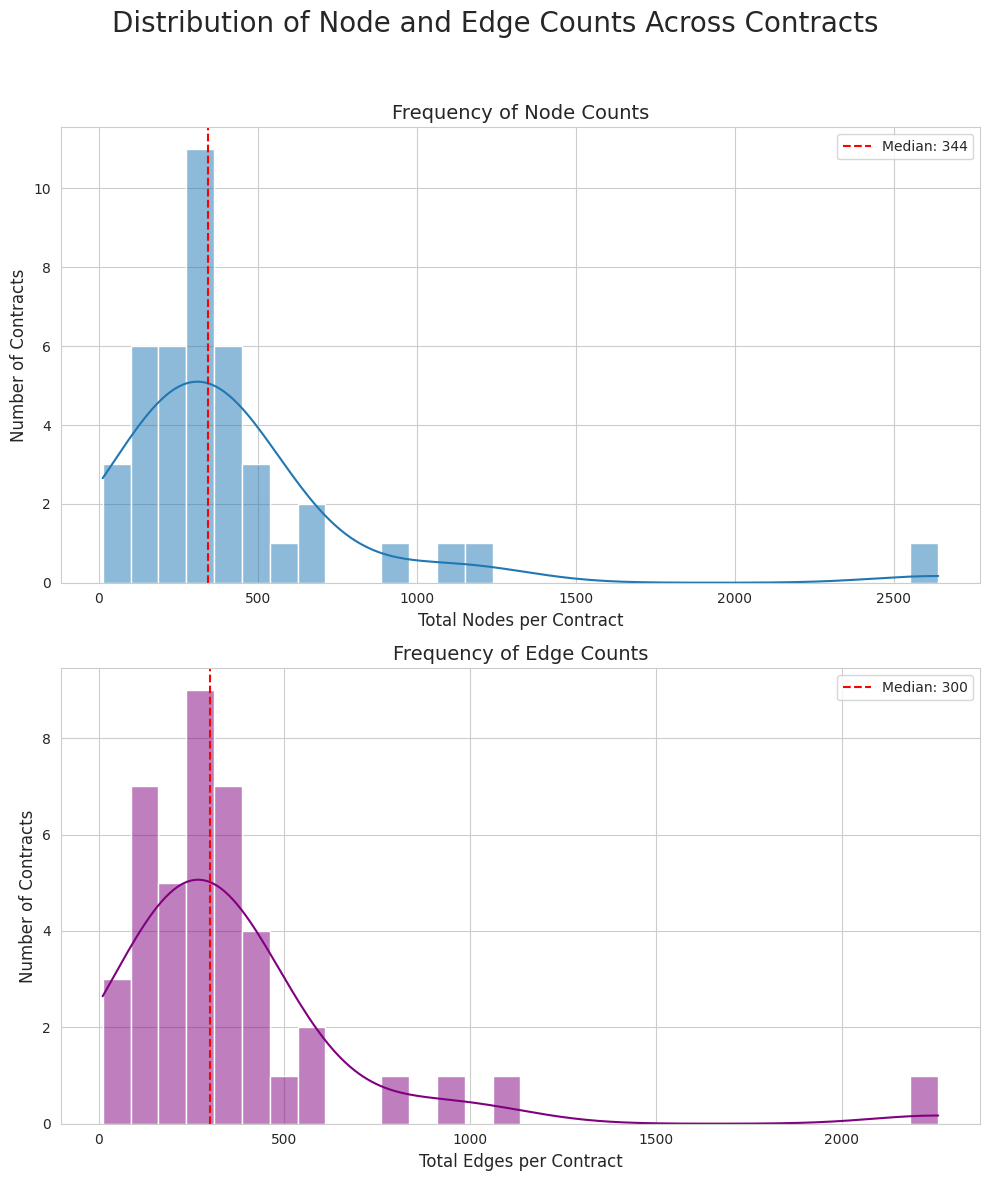

In [ ]:
#@title Plot Histograms
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("whitegrid")

if 'contract_counts_df' not in locals() or contract_counts_df.empty:
    print("❌ ERROR: The 'contract_counts_df' DataFrame is not available. Please run the previous cell.")
else:
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))
    fig.suptitle('Distribution of Node and Edge Counts Across Contracts', fontsize=20, y=0.98)

    #Histogram of Node Counts
    sns.histplot(data=contract_counts_df, x='total_nodes', ax=axes[0], bins=30, kde=True)
    axes[0].set_title('Frequency of Node Counts', fontsize=14)
    axes[0].set_xlabel('Total Nodes per Contract', fontsize=12)
    axes[0].set_ylabel('Number of Contracts', fontsize=12)
    median_nodes = contract_counts_df['total_nodes'].median()
    axes[0].axvline(median_nodes, color='red', linestyle='--', label=f'Median: {median_nodes:.0f}')
    axes[0].legend()

    #Histogram of Edge Counts
    sns.histplot(data=contract_counts_df, x='total_edges', ax=axes[1], bins=30, kde=True, color='purple') # CHANGED HERE
    axes[1].set_title('Frequency of Edge Counts', fontsize=14)
    axes[1].set_xlabel('Total Edges per Contract', fontsize=12)
    axes[1].set_ylabel('Number of Contracts', fontsize=12)
    median_edges = contract_counts_df['total_edges'].median()
    axes[1].axvline(median_edges, color='red', linestyle='--', label=f'Median: {median_edges:.0f}')
    axes[1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

/tmp/ipython-input-272348913.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_n_nodes, x='total_nodes', y='contract_id', ax=axes[0], palette='crest', orient='h')
/tmp/ipython-input-272348913.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_n_edges, x='total_edges', y='contract_id', ax=axes[1], palette='flare', orient='h')


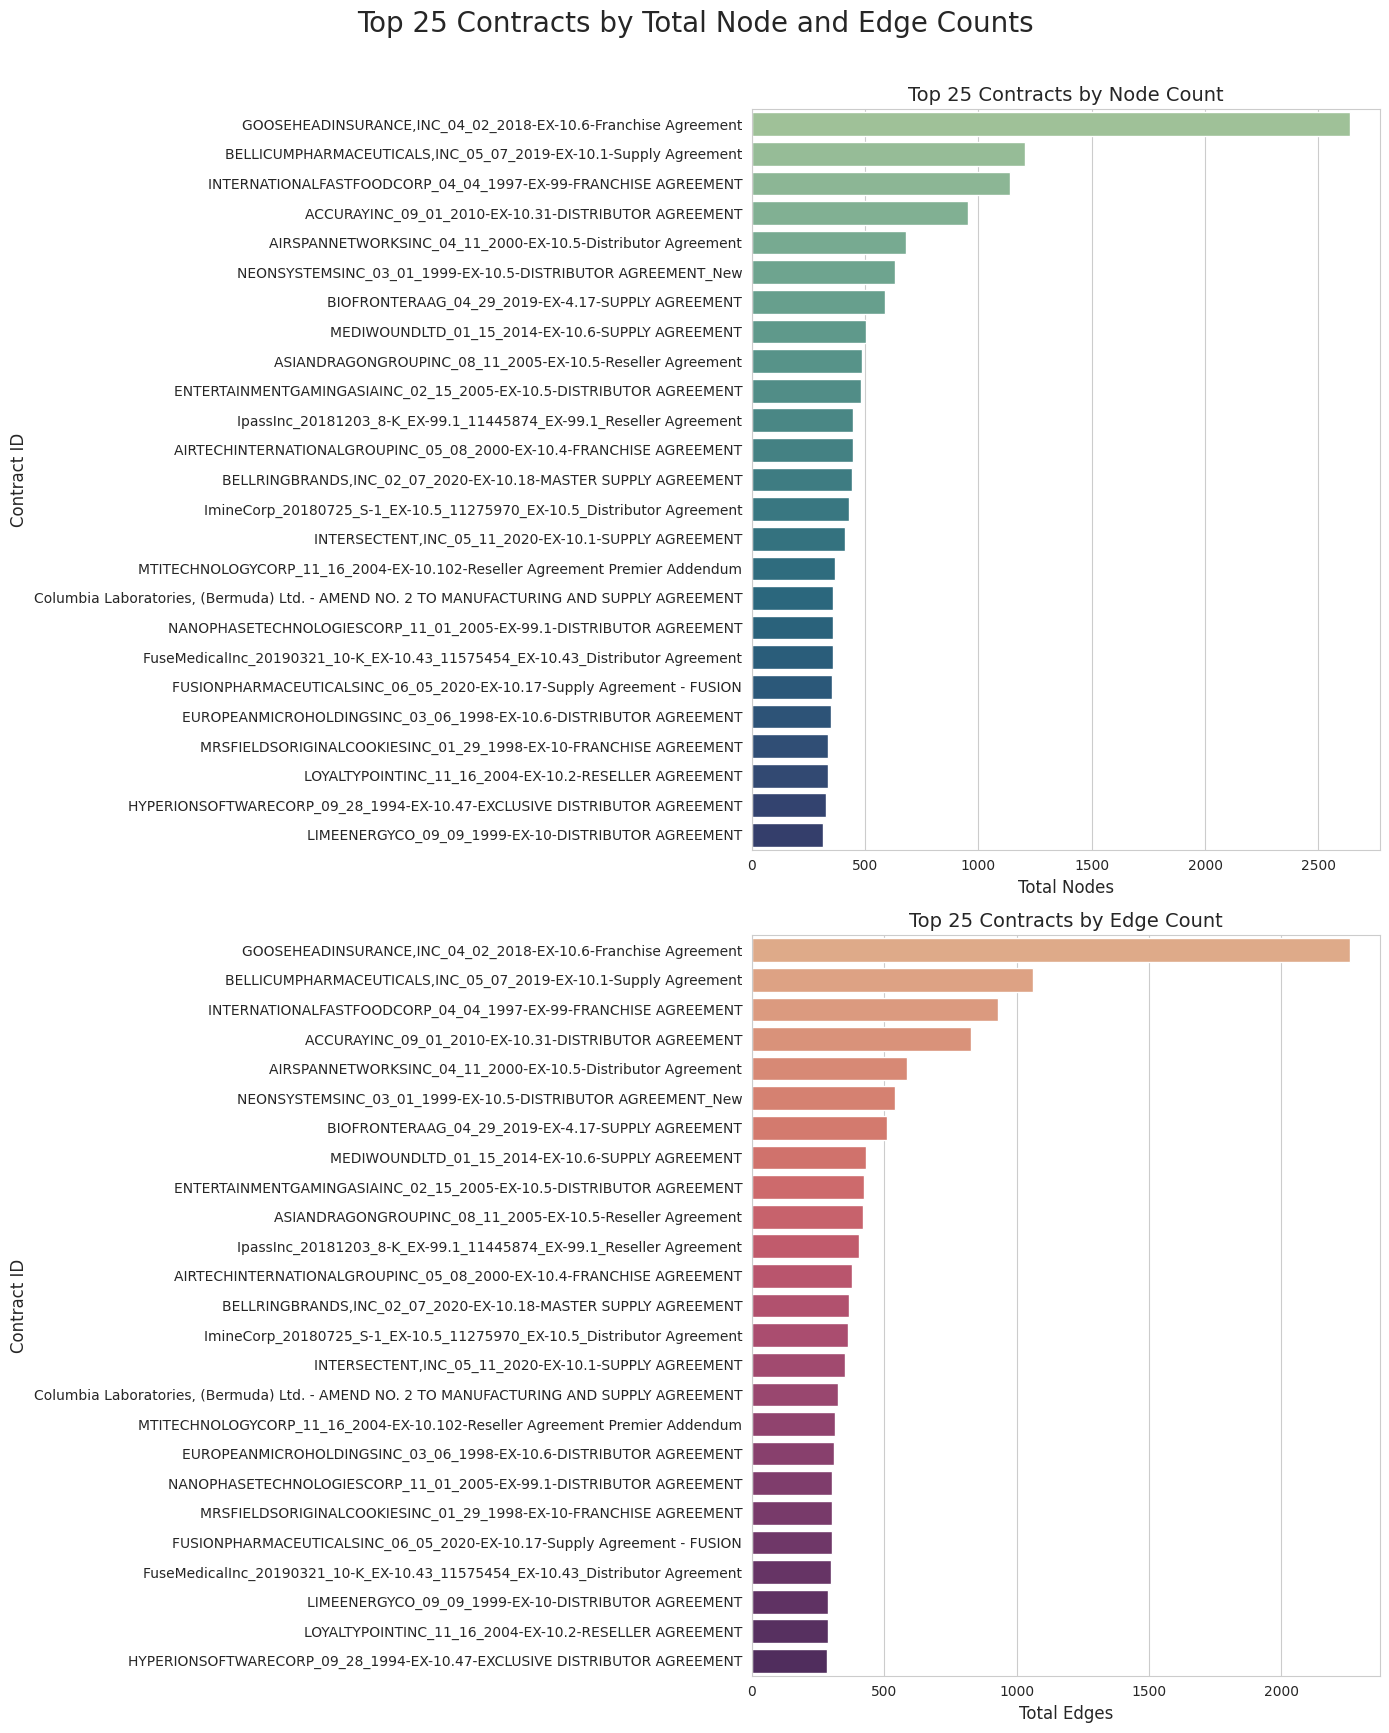

In [ ]:
if 'contract_counts_df' not in locals() or contract_counts_df.empty:
    print("❌ ERROR: The 'contract_counts_df' DataFrame is not available. Please run the previous cell.")
else:
    TOP_N = 25

    top_n_nodes = contract_counts_df.nlargest(TOP_N, 'total_nodes')
    top_n_edges = contract_counts_df.nlargest(TOP_N, 'total_edges')
    fig, axes = plt.subplots(2, 1, figsize=(14, 18))
    fig.suptitle(f'Top {TOP_N} Contracts by Total Node and Edge Counts', fontsize=20, y=0.96)

    #Top Contracts by Node Coun
    sns.barplot(data=top_n_nodes, x='total_nodes', y='contract_id', ax=axes[0], palette='crest', orient='h')
    axes[0].set_title(f'Top {TOP_N} Contracts by Node Count', fontsize=14)
    axes[0].set_xlabel('Total Nodes', fontsize=12)
    axes[0].set_ylabel('Contract ID', fontsize=12)

    #Top Contracts by Edge Count
    sns.barplot(data=top_n_edges, x='total_edges', y='contract_id', ax=axes[1], palette='flare', orient='h')
    axes[1].set_title(f'Top {TOP_N} Contracts by Edge Count', fontsize=14)
    axes[1].set_xlabel('Total Edges', fontsize=12)
    axes[1].set_ylabel('Contract ID', fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()